In [4]:
import pandas as pd
import numpy as np
from tokenize import generate_tokens
xrange = range
from io import StringIO
import matplotlib
import matplotlib.pyplot

In [7]:
# Helper funtions to process an array of strings from a csv

def parts(a):
    """Split a python-tokenizable expression on comma operators"""
    compos = [-1] # compos stores the positions of the relevant commas in the argument string
    compos.extend(t[2][1] for t in generate_tokens(StringIO(a).readline) if t[1] == ',')
    compos.append(len(a))
    return [ a[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]

#coverts to list of strings
def convertType(toConv, makeUpper):
    
    tcs = []
    for tc in toConv:
        tc = tc.replace('[','')
        tc = tc.replace(']','')
        tc = tc.replace('{','')
        tc = tc.replace('}','')
        tc = tc.replace(' \'','')
        tc = tc.replace('\'','')
        tc = tc.replace('@','')
        tc = tc.replace('-','')
        tc = tc.replace('#','')
        chain = parts(tc)
        
        chain2 = []
        for c in chain:
            chain2.append(c) 
        
        #make uppercase if specified
        chain3 = []
        if makeUpper:
            for c in chain2:
                chain3.append(c.upper())
            tcs.append(chain3)
        else:
            tcs.append(chain2)
        
    return np.array(tcs)

def fixDF(df):
    # remove empty columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # fix all string fields 
    for column in df:
        if (type(df[column][0]) == str):
            df[column] = convertType(df[column], False)
    
    return df 


In [8]:
# load in datasets
# load dataset and fix all string fields 

bills = pd.read_csv("bills_2019.csv")
bills = fixDF(bills)

legislators = pd.read_csv("legislators_2019.csv")
legislators = fixDF(legislators)

relationships = pd.read_csv("matrix_2019.csv")
relationships = fixDF(relationships)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Bill Analysis ###

In [9]:
# 1 Introduced
# 2 Engrossed
# 3 Enrolled
# 4 Passed
# 5 Vetoed

In [10]:
len(bills)

2497

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']
1    1373
3     848
2     259
4      17
Name: status, dtype: int64


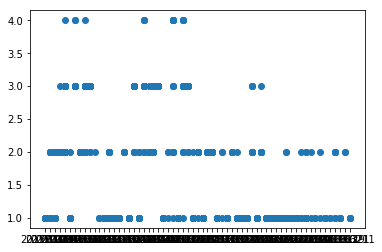

In [11]:
statuses = bills["status"]
print(list(bills))
print(statuses.value_counts())
matplotlib.pyplot.plot_date(bills["status_date"], bills["status"])

In [12]:
sp = bills['sponsor_party']
ps = []
for s in sp:
    ps.append(s[0])
unique, counts = np.unique(ps, return_counts=True)
print(dict(zip(unique, counts)))

{'': 47, 'D': 2450}


In [13]:
passed_bills = bills[(bills["status"] == 4) | (bills["status"] == 3)]

In [14]:
print(len(passed_bills))

865


In [15]:
print(list(legislators))

['name', 'party', 'district', 'role', 'people_id', 'committee_sponsor', 'all_sponsored_bills_count', 'unspecified_sponsored_bills_count', 'primary_sponsored_bills_count', 'co_sponsored_bills_count', 'joint_sponsored_bills_count', 'all_sponsored_bills', 'unspecified_sponsored_bills', 'primary_sponsored_bills', 'co_sponsored_bills', 'joint_sponsored_bills', 'all_sponsored_bills_status', 'unspecified_sponsored_bills_status', 'primary_sponsored_bills_status', 'co_sponsored_bills_status', 'joint_sponsored_bills_status', 'all_sponsored_bills_passed', 'unspecified_sponsored_bills_passed', 'primary_sponsored_bills_passed', 'co_sponsored_bills_passed', 'joint_sponsored_bills_passed', 'all_sponsored_bills_avg', 'unspecified_sponsored_bills_avg', 'primary_sponsored_bills_avg', 'co_sponsored_bills_avg', 'joint_sponsored_bills_avg']


### Legislator Analysis ###

In [16]:
# Best Primary Bill AVG
sm = legislators[["name","party","primary_sponsored_bills_passed","primary_sponsored_bills_count","primary_sponsored_bills_avg","co_sponsored_bills_avg","co_sponsored_bills_count", "co_sponsored_bills_passed", "committee_sponsor","people_id"]]
sm = sm[sm['committee_sponsor'] != 1]
sm = sm.sort_values(by=['primary_sponsored_bills_avg', 'primary_sponsored_bills_count'], ascending=[False,False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_avg"])))
sm.head(50)

mean: 0.3057712884499195
median: 0.26666666666666666


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
1,Maggie McIntosh,D,5,5,1.000000,0.434783,69,30,0,4649
2,Jerry Clark,D,4,4,1.000000,0.157143,70,11,0,19026
3,Charles Otto,D,4,4,1.000000,0.138462,65,9,0,12078
4,Heather Bagnall,D,3,3,1.000000,0.571429,105,60,0,20588
5,Jesse Pippy,D,3,3,1.000000,0.310345,29,9,0,20534
6,Andrea Harrison,D,1,1,1.000000,0.488372,43,21,0,21279
7,Brian Chisholm,D,1,1,1.000000,0.373913,115,43,0,20530
8,Jessica Feldmark,D,1,1,1.000000,0.435294,85,37,0,20860
9,Courtney Watson,D,1,1,1.000000,0.440000,50,22,0,20857


In [17]:
sm.to_csv("legislators_sm_2019.csv")

In [18]:
# worst Primary Bill AVG
sm = sm.sort_values(by=['primary_sponsored_bills_avg',"primary_sponsored_bills_count"], ascending=[True,False]).reset_index(drop=True)
sm.head(30)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Neil Parrott,D,0,16,0.0,0.092308,65,6,0,12189
1,April Rose,D,0,12,0.0,0.204301,93,19,0,17670
2,Bob Cassilly,D,0,11,0.0,0.283582,67,19,0,17244
3,Jason Buckel,D,0,10,0.0,0.216667,120,26,0,17231
4,Mary Ann Lisanti,D,0,10,0.0,0.430556,72,31,0,17442
5,Mark Chang,D,0,9,0.0,0.381579,76,29,0,17233
6,Frank Conaway,D,0,8,0.0,0.500000,58,29,0,4531
7,Bob Long,D,0,8,0.0,0.200000,50,10,0,17424
8,Johnny Mautz,D,0,8,0.0,0.174603,63,11,0,17425
9,Vaughn Stewart,D,0,7,0.0,0.320513,156,50,0,20797


In [19]:
# most primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(20)

mean: 3.606382978723404
median: 3.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Brian Feldman,D,16,22,0.727273,0.573913,115,66,0,4575
2,Michael Busch,No Party,16,50,0.320000,0.727273,11,8,0,4569
3,Paul Pinsky,D,14,26,0.538462,0.508772,57,29,0,4725
4,Antonio Hayes,D,14,33,0.424242,0.520833,96,50,0,17321
5,Ronald Young,D,13,30,0.433333,0.439394,132,58,0,11711
6,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171
7,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
8,Clarence Lam,D,12,44,0.272727,0.536082,97,52,0,17170
9,Benjamin Kramer,D,12,27,0.444444,0.492537,67,33,0,4597


In [34]:
# least primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(50)

mean: 3.606382978723404
median: 3.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Veronica Turner,D,0,5,0.000000,0.441558,77,34,0,4554
1,Elizabeth Proctor,D,0,1,0.000000,0.428571,56,24,0,17833
2,Frank Conaway,D,0,8,0.000000,0.500000,58,29,0,4531
3,Jason Buckel,D,0,10,0.000000,0.216667,120,26,0,17231
4,Wayne Hartman,D,0,1,0.000000,0.237288,59,14,0,20533
5,Sid Saab,D,0,5,0.000000,0.383333,120,46,0,17242
6,Darryl Barnes,D,0,4,0.000000,0.466667,60,28,0,17325
7,Ric Metzgar,D,0,6,0.000000,0.432203,118,51,0,17403
8,Johnny Mautz,D,0,8,0.000000,0.174603,63,11,0,17425
9,Trent Kittleman,D,0,3,0.000000,0.174603,63,11,0,17378


In [35]:
print(len(sm))

188


In [36]:
# most primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_count"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_count"])))
sm.head(30)

mean: 11.882978723404255
median: 10.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Michael Busch,No Party,16,50,0.320000,0.727273,11,8,0,4569
2,Clarence Lam,D,12,44,0.272727,0.536082,97,52,0,17170
3,Jill Carter,D,7,43,0.162791,0.510417,96,49,0,4584
4,Katherine Klausmeier,D,9,43,0.209302,0.500000,76,38,0,4686
5,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171
6,Susan Lee,D,12,37,0.324324,0.500000,124,62,0,4626
7,Antonio Hayes,D,14,33,0.424242,0.520833,96,50,0,17321
8,Chris West,D,6,32,0.187500,0.361538,130,47,0,17243
9,Ronald Young,D,13,30,0.433333,0.439394,132,58,0,11711


In [37]:
# least primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(70)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Jen Terrasa,D,0,0,0.000000,0.387755,98,38,0,20868
1,Debra Davis,D,0,0,0.000000,0.457143,35,16,0,20859
2,Jay Jalisi,D,0,0,0.000000,0.355556,90,32,0,17169
3,Tawanna Gaines,D,0,1,0.000000,0.490566,53,26,0,4660
4,Dalya Attar,D,0,1,0.000000,0.411765,34,14,0,20930
5,Elizabeth Proctor,D,0,1,0.000000,0.428571,56,24,0,17833
6,Courtney Watson,D,1,1,1.000000,0.440000,50,22,0,20857
7,Jessica Feldmark,D,1,1,1.000000,0.435294,85,37,0,20860
8,Wayne Hartman,D,0,1,0.000000,0.237288,59,14,0,20533
9,Brian Chisholm,D,1,1,1.000000,0.373913,115,43,0,20530


In [38]:
# most co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["co_sponsored_bills_passed"])))
sm.head(10)

mean: 32.962765957446805
median: 31.5


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Robbyn Lewis,D,4,10,0.400000,0.442308,208,92,0,18731
1,Terri Hill,D,4,20,0.200000,0.554688,128,71,0,17167
2,Joseline PenaMelnyk,D,5,8,0.625000,0.496503,143,71,0,4561
3,Erek Barron,D,9,25,0.360000,0.507143,140,71,0,17319
4,Ariana Kelly,D,7,11,0.636364,0.450331,151,68,0,11634
5,Mary Washington,D,3,16,0.187500,0.455172,145,66,0,11917
6,Brian Feldman,D,16,22,0.727273,0.573913,115,66,0,4575
7,Brooke Lierman,D,7,18,0.388889,0.458333,144,66,0,17237
8,Karen Young,D,3,13,0.230769,0.585586,111,65,0,17248
9,Guy Guzzone,D,7,23,0.304348,0.470588,136,64,0,4636


In [39]:
# least co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Mark Fisher,D,0,7,0.000000,0.100000,30,3,0,11554
1,Nino Mangione,D,0,2,0.000000,0.053571,56,3,0,20933
2,Richard Impallaria,D,0,4,0.000000,0.181818,22,4,0,4638
3,Neil Parrott,D,0,16,0.000000,0.092308,65,6,0,12189
4,William Wivell,D,1,9,0.111111,0.189189,37,7,0,17669
5,Seth Howard,D,2,9,0.222222,0.148936,47,7,0,17324
6,Mike Rogers,D,2,3,0.666667,0.194444,36,7,0,20592
7,Michael Busch,No Party,16,50,0.320000,0.727273,11,8,0,4569
8,Warren Miller,D,4,10,0.400000,0.190476,42,8,0,11771
9,Charles Otto,D,4,4,1.000000,0.138462,65,9,0,12078


In [40]:
# AVG co sponsors highest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["co_sponsored_bills_avg"])))
sm.head(10)

mean: 0.39567678453687233
median: 0.4108003857280617


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Michael Busch,No Party,16,50,0.320000,0.727273,11,8,0,4569
2,Nick Charles,D,0,1,0.000000,0.656250,96,63,0,20931
3,Harry Bhandari,D,1,4,0.250000,0.654545,55,36,0,20790
4,Shane Pendergrass,D,4,5,0.800000,0.653846,78,51,0,4635
5,Samuel Rosenberg,D,3,29,0.103448,0.651685,89,58,0,4581
6,William Ferguson,D,10,17,0.588235,0.644737,76,49,0,11453
7,Ken Kerr,D,2,5,0.400000,0.644444,90,58,0,20792
8,Robert Zirkin,D,3,25,0.120000,0.619048,42,26,0,4713
9,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664


In [41]:
# AVG co sponsors lowest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Nino Mangione,D,0,2,0.000000,0.053571,56,3,0,20933
1,Neil Parrott,D,0,16,0.000000,0.092308,65,6,0,12189
2,Mark Fisher,D,0,7,0.000000,0.100000,30,3,0,11554
3,Charles Otto,D,4,4,1.000000,0.138462,65,9,0,12078
4,Barrie Ciliberti,D,0,5,0.000000,0.147059,68,10,0,17553
5,Seth Howard,D,2,9,0.222222,0.148936,47,7,0,17324
6,Steven Arentz,D,1,4,0.250000,0.150685,73,11,0,16083
7,Jerry Clark,D,4,4,1.000000,0.157143,70,11,0,19026
8,Jay Jacobs,D,2,7,0.285714,0.171429,70,12,0,11449
9,Haven Shoemaker,D,1,9,0.111111,0.172727,110,19,0,17427


In [42]:
# co sponsors count most
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_count"])))
print("median: " + str(np.median(sm["co_sponsored_bills_count"])))
sm.head(10)

mean: 83.10106382978724
median: 77.5


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Robbyn Lewis,D,4,10,0.400000,0.442308,208,92,0,18731
1,David Moon,D,6,22,0.272727,0.284024,169,48,0,17238
2,Vaughn Stewart,D,0,7,0.000000,0.320513,156,50,0,20797
3,Jheanelle Wilkins,D,5,15,0.333333,0.357616,151,54,0,19199
4,Ariana Kelly,D,7,11,0.636364,0.450331,151,68,0,11634
5,Susan Krebs,D,4,14,0.285714,0.324324,148,48,0,4629
6,Mary Washington,D,3,16,0.187500,0.455172,145,66,0,11917
7,Brooke Lierman,D,7,18,0.388889,0.458333,144,66,0,17237
8,Joseline PenaMelnyk,D,5,8,0.625000,0.496503,143,71,0,4561
9,Shelly Hettleman,D,9,12,0.750000,0.446809,141,63,0,17377


In [43]:
# co sponsors count least
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(10)

,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Michael Busch,No Party,16,50,0.320000,0.727273,11,8,0,4569
1,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
2,Luke Clippinger,D,4,7,0.571429,0.550000,20,11,0,11447
3,Richard Impallaria,D,0,4,0.000000,0.181818,22,4,0,4638
4,Jesse Pippy,D,3,3,1.000000,0.310345,29,9,0,20534
5,Mark Fisher,D,0,7,0.000000,0.100000,30,3,0,11554
6,Talmadge Branch,D,1,4,0.250000,0.515152,33,17,0,4602
7,Dalya Attar,D,0,1,0.000000,0.411765,34,14,0,20930
8,Debra Davis,D,0,0,0.000000,0.457143,35,16,0,20859
9,Mike Rogers,D,2,3,0.666667,0.194444,36,7,0,20592


In [44]:
# Split by party

Rdel = sm.loc[sm['party'] == "R"]
Ddel = sm.loc[sm['party'] == "D"]

print("# of rep deligates: " + str(len(Rdel)))
print("# of dem deligates: " + str(len(Ddel)))
print("\n")

# primary counts
print("Rep primary count mean: " + str(np.mean(Rdel["primary_sponsored_bills_count"])))
print("Rep primary count median: " + str(np.median(Rdel["primary_sponsored_bills_count"])))
print("Dem primary count mean: " + str(np.mean(Ddel["primary_sponsored_bills_count"])))
print("Dem primary count median: " + str(np.median(Ddel["primary_sponsored_bills_count"])))
print("\n")

# Primary Bill AVG
print("Rep primary bill avg mean: " + str(np.mean(Rdel["primary_sponsored_bills_avg"])))
print("Rep primary bill avg median: " + str(np.median(Rdel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg mean: " + str(np.mean(Ddel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg median: " + str(np.median(Ddel["primary_sponsored_bills_avg"])))
print("\n")

# Primary Bill AVG
print("Rep primary bills passed mean: " + str(np.mean(Rdel["primary_sponsored_bills_passed"])))
print("Rep primary bills passed median: " + str(np.median(Rdel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed mean: " + str(np.mean(Ddel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed median: " + str(np.median(Ddel["primary_sponsored_bills_passed"])))
print("\n")

# of rep deligates: 0
# of dem deligates: 187


Rep primary count mean: nan
Rep primary count median: nan
Dem primary count mean: 11.679144385026738
Dem primary count median: 10.0


Rep primary bill avg mean: nan
Rep primary bill avg median: nan
Dem primary bill avg mean: 0.3056951990833416
Dem primary bill avg median: 0.26666666666666666


Rep primary bills passed mean: nan
Rep primary bills passed median: nan
Dem primary bills passed mean: 3.5401069518716577
Dem primary bills passed median: 3.0




### Relationships Analysis ###

In [45]:
print(list(legislators))

['name', 'party', 'district', 'role', 'people_id', 'committee_sponsor', 'all_sponsored_bills_count', 'unspecified_sponsored_bills_count', 'primary_sponsored_bills_count', 'co_sponsored_bills_count', 'joint_sponsored_bills_count', 'all_sponsored_bills', 'unspecified_sponsored_bills', 'primary_sponsored_bills', 'co_sponsored_bills', 'joint_sponsored_bills', 'all_sponsored_bills_status', 'unspecified_sponsored_bills_status', 'primary_sponsored_bills_status', 'co_sponsored_bills_status', 'joint_sponsored_bills_status', 'all_sponsored_bills_passed', 'unspecified_sponsored_bills_passed', 'primary_sponsored_bills_passed', 'co_sponsored_bills_passed', 'joint_sponsored_bills_passed', 'all_sponsored_bills_avg', 'unspecified_sponsored_bills_avg', 'primary_sponsored_bills_avg', 'co_sponsored_bills_avg', 'joint_sponsored_bills_avg']


In [46]:
# most cosponsers

print(list(relationships))

relationships = relationships.sort_values(by=['co_bills_total'], ascending=False)
rsm = relationships[["first_name","second_name","co_bills_total", "co_bills_status"]]
rsm = rsm.sort_values(by=['co_bills_total'], ascending=False)
rsm.head(40)

['relationship', 'first_name', 'second_name', 'co_bills', 'co_bills_status', 'co_bills_total']


,first_name,second_name,co_bills_total,co_bills_status
0,Susan Lee,William Smith,31,"[3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1..."
1,Kathy Szeliga,The Speaker,25,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1..."
2,Jack Bailey,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1..."
9,Ric Metzgar,The Speaker,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3..."
6,Nicholaus Kipke,The Speaker,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1..."
8,Chris West,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1..."
3,Mary Carozza,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1..."
4,Adelaide Eckardt,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1..."
5,Jason Gallion,Thomas Miller,24,"[2, 1, 1, 1, 3, 1, 2, 1, 2, 2, 3, 2..."
7,Brian Chisholm,The Speaker,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1..."


In [47]:
# least cosponsers
print("Reationships with no cosponserships: " + str(len(rsm.loc[rsm['co_bills_total'] == 0])))
print("Reationships with at least 1 cosponsership: " + str(len(rsm.loc[rsm['co_bills_total'] != 0])))

Reationships with no cosponserships: 20713
Reationships with at least 1 cosponsership: 5393
